In [3]:
%matplotlib notebook
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation

import traceback, functools, pprint, math, random

import pymunk
import pymunk.matplotlib_util
from pymunk.vec2d import Vec2d
from IPython.display import HTML

def print_errors_to_stdout(fun):
    @functools.wraps(fun)
    def wrapper(*args,**kw):
        try:
            return fun(*args,**kw)
        except Exception:
            traceback.print_exc()
            raise
    return wrapper

In [4]:
nx, ny = 501, 501

<IPython.core.display.Javascript object>


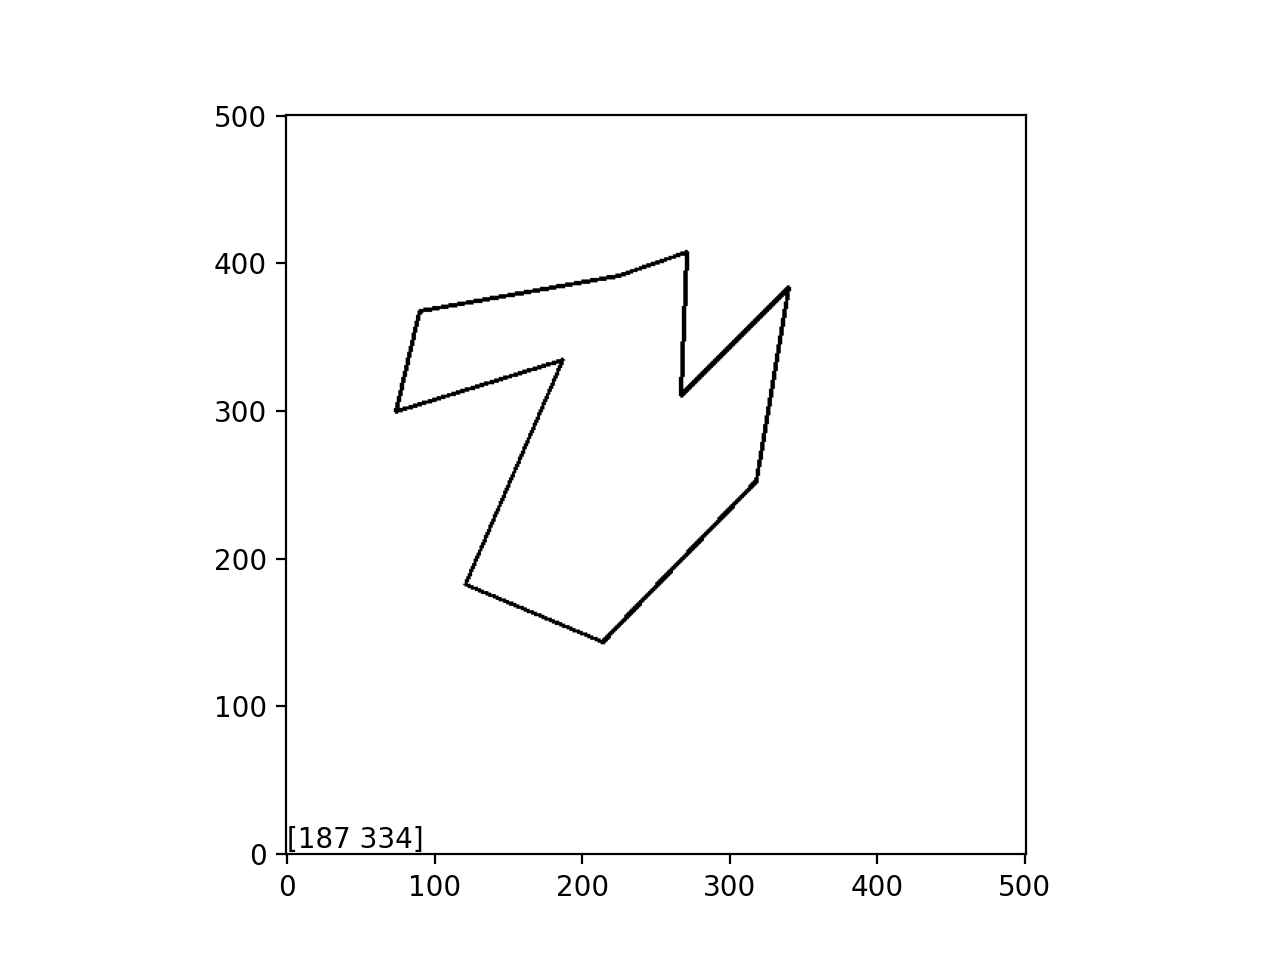

In [3]:
plt.figure()
img = np.full((nx, ny, 3), 255, dtype='uint8')

plt.ion()

im = plt.imshow(img, origin='lower')
fig = plt.gcf()
ax = plt.gca()

text=ax.text(0,0, "", va="bottom", ha="left")

points = np.array([], dtype='uint8').reshape((-1, 2))
snap_threshold = 10

@print_errors_to_stdout
def on_press(event):
    global points
    
    if plt.isinteractive():
        # debug printout
        # tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
        # text.set_text(tx)

        x_coord, y_coord = int(event.xdata), int(event.ydata)
        point = np.array([x_coord, y_coord])
        
        if len(points) > 1 and all(np.abs(point - points[0]) < snap_threshold):
            point = points[0]
            plt.ioff()
        
        points = np.vstack((points, point))
        text.set_text(f'{point}')

        if len(points) > 1:
            n = len(points)
            cv2.line(img, tuple(points[n-2]), tuple(points[n-1]), (0, 0, 0), thickness=2)

        im.set_data(img)

        plt.draw()

@print_errors_to_stdout
def on_move(event):
    if plt.isinteractive() and event.inaxes is not None:
        tmp_img = np.copy(img)
        
        x_coord, y_coord = int(event.xdata), int(event.ydata)
        point = np.array([x_coord, y_coord])
        
        if len(points) >= 1:
            n = len(points)
            
            if all(np.abs(point - points[0]) < snap_threshold):
                point = points[0]
                
            cv2.line(tmp_img, tuple(points[n-1]), tuple(point), (0, 0, 0), thickness=2)
            
        im.set_data(tmp_img)

        plt.draw()
        
cid = fig.canvas.mpl_connect('button_press_event', on_press)
cid = fig.canvas.mpl_connect('motion_notify_event', on_move)

In [12]:
# points = np.array([(-42, -41), (48, -41), (39, 25), (-34, 59)]) # 4gon in paper
# points = np.array([(-42, -41), (48, -41), (48, 40), (-42, 40)]) # Rectangular box
points = np.array([(-25, -33), (25, -33), (25, 20), (0, 45), (-25, 20)]) # House shape
# points = np.array([[233, 360], [131, 268], [147, 164], [243, 123], [318, 300], [245, 292], [233, 360]]) # another test shape

<IPython.core.display.Javascript object>


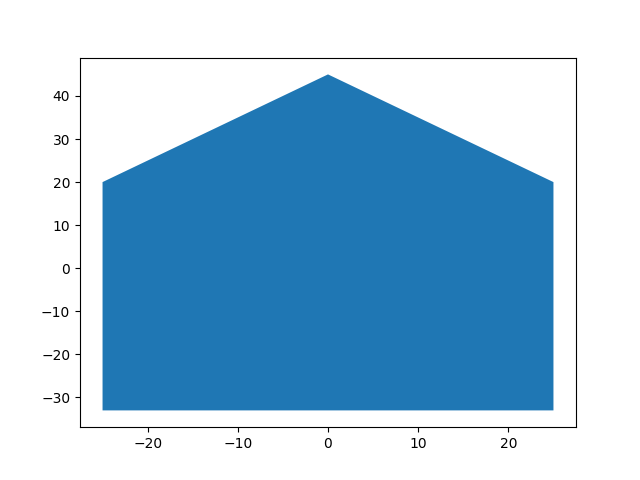

In [13]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
plt.show()

In [5]:
def signed_area(p1, p2, p3):
    """
    Returns the twice the signed area of a triangle defined by the points (p1, p2, p3).
    The sign is positive if and only if (p1, p2, p3) form a counterclockwise cycle
    (a left turn). If the points are colinear, then this returns 0. If the points form
    a clockwise cycle, this returns a negative value.
    
    This method is described in further detail in Preparata and Shamos (1985). 
    """
    mat = np.hstack((np.vstack((p1, p2, p3)), np.ones((3, 1)))).astype('int32')
    return round(np.linalg.det(mat)) # since matrix only has integers, determinant should itself be an integer

def convex_hull(points):
    """
    Returns the convex hull of a set of points, which defines a convex polygon. 
    The returned points form a counterclockwise sequence.
    
    This is an implementation of Jarvis's march algorithm, which runs in O(nh) time.
    """
    assert len(points) >= 3
    
    l_idx = np.argmin(points, axis=0)[0]
    l = points[l_idx]
    
    result = [l]
    start = 0
    
    p, q = l_idx, None
    while True:
        q = (p + 1) % len(points)
        
        for i in range(len(points)):
            if i == p:
                continue
            v1, v2 = points[i]-points[p], points[q]-points[i]
            d = signed_area(points[p], points[i], points[q])
            if d > 0 or (d == 0 and np.linalg.norm(v1) > np.linalg.norm(v2)):
                q = i
                
        p = q
        if p == l_idx:
            break
        result.append(points[q])
        
    return np.array(result)

# ch = convex_hull(points[:-1])
ch = convex_hull(points)

<IPython.core.display.Javascript object>


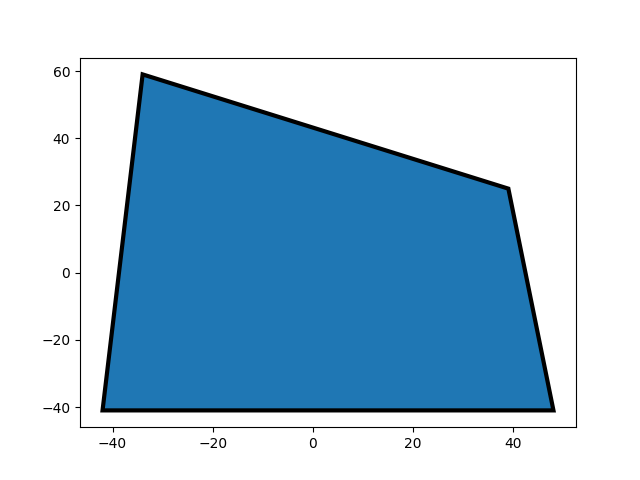

In [6]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
plt.fill(ch[:, 0], ch[:, 1], facecolor='none', edgecolor='black', linewidth=3)
plt.show()

In [7]:
def antipodal_pairs(points):
    """
    Returns the antipodal pairs of a convex polygon. The points must be in
    a counterclockwise sequence.
    
    This procedure is described in further detail in Preparata and Shamos (1985).
    """
    res = []
    n = len(points)
    def _next(i):
        return (i + 1) % n
    
    p = n - 1
    q = _next(p)
    while signed_area(points[p], points[_next(p)], points[_next(q)]) > \
          signed_area(points[p], points[_next(p)], points[q]):
        q = _next(q)
        
    p0, q0 = 0, q

    while q != p0:
        # print(res)
        p = _next(p)
        res.append([p, q])
        while signed_area(points[p], points[_next(p)], points[_next(q)]) > \
              signed_area(points[p], points[_next(p)], points[q]):
            q = _next(q)
            if (p, q) != (q0, p0): # and sorted([p, q]) not in res:
                res.append([p, q])
            else:
                break
        if signed_area(points[p], points[_next(p)], points[_next(q)]) == \
           signed_area(points[p], points[_next(p)], points[q]):
            if (p, q) != (q0, n-1): # and sorted([p, q]) not in res:
                res.append([p,_next(q)])
            else:
                break
                
    return np.array(res)

<IPython.core.display.Javascript object>


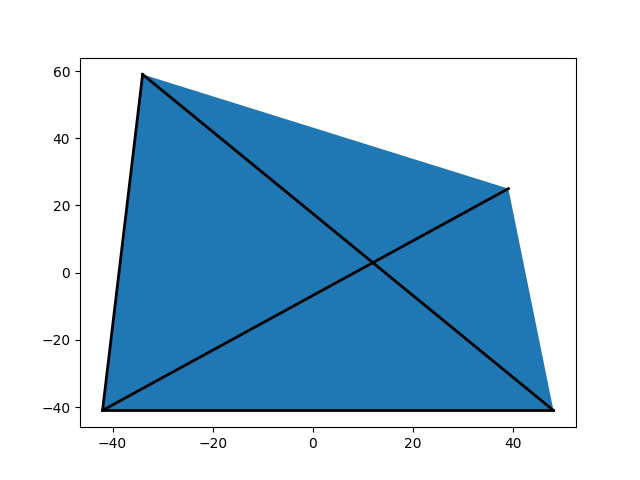

In [8]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
# plt.fill(ch[:, 0], ch[:, 1], facecolor='none', edgecolor='black', linewidth=3)
for p1, p2 in antipodal_pairs(ch):
    x1, y1 = ch[p1]
    x2, y2 = ch[p2]
    plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
plt.show()

In [19]:
def plot_angle(point, angle, length=50, color='k', **kwargs):
    slope = np.tan(angle)
    plot_slope(point, slope, length, color)
    
def plot_slope(point, slope, length=50, color='k', **kwargs):
    length = length / 2
    x, y = point
    l = math.sqrt(length**2/(slope**2+1))
    plt.plot([x-l, x+l], [y-l*slope, y+l*slope], color=color, linestyle='-', linewidth=2)

<IPython.core.display.Javascript object>


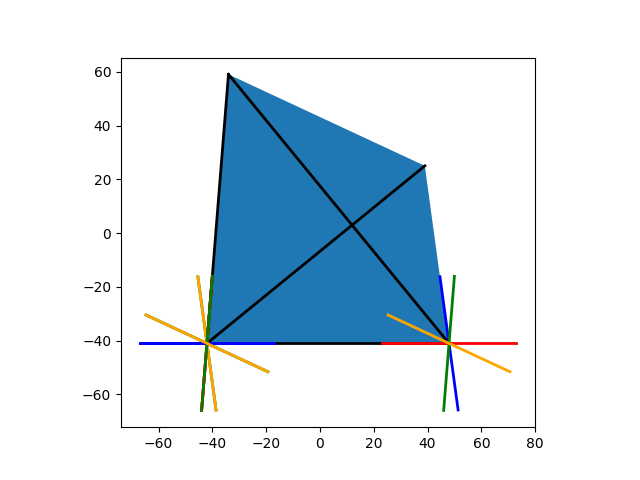

Angle of perpendicular line from [-42 -41] to [ 48 -41]: 1.5707963267948966
3.141592653589793 1.4909663410826592
1.7063240407803975 0.0
Maximum angle of parallel supporting lines: 1.7063240407803975, modulo pi: 1.7063240407803975
Angle of perpendicular line from [-42 -41] to [39 25]: 2.2545056384292677
3.141592653589793 1.4909663410826592
2.7057156811824083 1.7063240407803975
Maximum angle of parallel supporting lines: 2.7057156811824083, modulo pi: 2.7057156811824083
Angle of perpendicular line from [-42 -41] to [-34  59]: 3.061762667877556
3.141592653589793 1.4909663410826592
4.632558994672452 2.7057156811824083
Maximum angle of parallel supporting lines: 3.141592653589793, modulo pi: 0.0
Angle of perpendicular line from [ 48 -41] to [-34  59]: 0.6868176497586452
4.84791669437019 3.141592653589793
4.632558994672452 2.7057156811824083
Maximum angle of parallel supporting lines: 4.632558994672452, modulo pi: 1.4909663410826592


In [20]:
plt.figure()
plt.fill(points[:, 0], points[:, 1])
# plt.fill(ch[:, 0], ch[:, 1], facecolor='none', edgecolor='black', linewidth=3)

n = len(ch)
pairs = antipodal_pairs(ch)

for p1, p2 in pairs:
    x1, y1 = ch[p1]
    x2, y2 = ch[p2]
    plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
    
    v = ch[p2] - ch[p1]
    angle = np.arctan(v[1]/v[0] if v[0] != 0 else np.sign(v[1]) * np.inf) + np.pi/2
    print(f'Angle of perpendicular line from {ch[p1]} to {ch[p2]}: {angle}')
    
    v1, v2 = ch[p1] - ch[(p1+1)%n], ch[(p1-1)%n] - ch[p1]
    v3, v4 = ch[(p2+1)%n] - ch[p2], ch[p2] - ch[(p2-1)%n]
    
    a1, a2 = np.arctan2(*v1[::-1]) % (2*np.pi), np.arctan2(*v2[::-1]) 
    a3, a4 = np.arctan2(*v3[::-1]) % (2*np.pi), np.arctan2(*v4[::-1]) 
    print(a1, a2)
    print(a3, a4)
    # print(f'Range of movement of parallel supporting lines: [{max(a2, a4)}, {min(a1, a3)})')
    print(f'Maximum angle of parallel supporting lines: {min(a1, a3)}, modulo pi: {min(a1, a3) % np.pi}')
    plot_angle(ch[p1], a1, color='b', length=50)
    plot_angle(ch[p1], a2, color='r', length=50)
    plot_angle(ch[p1], a3, color='g', length=50)
    plot_angle(ch[p1], a4, color='orange', length=50)
    #slope = -1/(v[1]/v[0])
    
    #plot_angle(ch[p1], angle)
    #plot_angle(ch[p2], angle)

plt.gca().set_aspect(aspect='equal')
plt.show()

In [21]:
def make_diameter_function(convex_hull):
    """Returns a diameter function of a convex polygon"""
    pairs = antipodal_pairs(convex_hull)
    
    pieces = []
    n = len(convex_hull)
    for p1, p2 in pairs:
        v = convex_hull[p2] - convex_hull[p1]  # vector from p1 to p2
        
        v1, v2 = convex_hull[p1] - convex_hull[(p1+1)%n], convex_hull[(p1-1)%n] - convex_hull[p1]
        v3, v4 = convex_hull[(p2+1)%n] - convex_hull[p2], convex_hull[p2] - convex_hull[(p2-1)%n]

        a1, a2 = np.arctan2(*v1[::-1]) % (2*np.pi), np.arctan2(*v2[::-1]) 
        a3, a4 = np.arctan2(*v3[::-1]) % (2*np.pi), np.arctan2(*v4[::-1]) 
        
        max_angle = min(a1, a3) % np.pi
        length = np.linalg.norm(v)  # length of the vector (chord)
        initial_angle = np.arctan(v[1]/v[0] if v[0] != 0 else np.sign(v[1]) * np.inf) + np.pi/2  # angle of the parallel supporting 
                                                        # lines that are perpendicular to the chord
        pieces.append((max_angle, length, initial_angle))
        
    piecewise_func = []
    for i in range(len(pieces)):
        min_ = pieces[(i-1) % len(pieces)][0]
        max_ = pieces[i][0]
        if max_ < min_:
            # wrapped around
            piecewise_func.append((min_, np.pi) + pieces[i][1:])
            piecewise_func.append((0, max_) + pieces[i][1:])
        else:
            piecewise_func.append((min_, max_) + pieces[i][1:])
        
    # remove parallel edges
    piecewise_func = sorted([p for p in piecewise_func if not np.isclose(p[0], p[1])], key=lambda x: x[0])
    
    def diameter_func(theta):
        theta = theta % np.pi
        for p in piecewise_func:
            min_, max_, l, i = p
            if min_ <= theta < max_:
                return l * np.abs(np.cos(theta-i))
        
    return np.array(piecewise_func), diameter_func

In [22]:
def find_extrema(piecewise_func, diameter_func):
    maxima = []
    for p in piecewise_func:
        min_, max_, l, i = p
        if min_ <= i < max_:
            maxima.append(i)
            maxima.append(i+np.pi)
    maxima.sort()
    ranges = [0] + maxima + [2*np.pi]
    
    minima = []
    discont = np.append(piecewise_func[:, :2].flatten(), piecewise_func[:, :2].flatten()+np.pi)
    for i in range(len(ranges)-1):
        valid_points = discont[np.logical_and(ranges[i] <= discont, discont <= ranges[i+1])]
        minimum = min(valid_points, key=diameter_func)
        
        minima.append(minimum)
        # minima.append(minimum+np.pi)
        
    return np.array(maxima), np.array(minima)

<IPython.core.display.Javascript object>


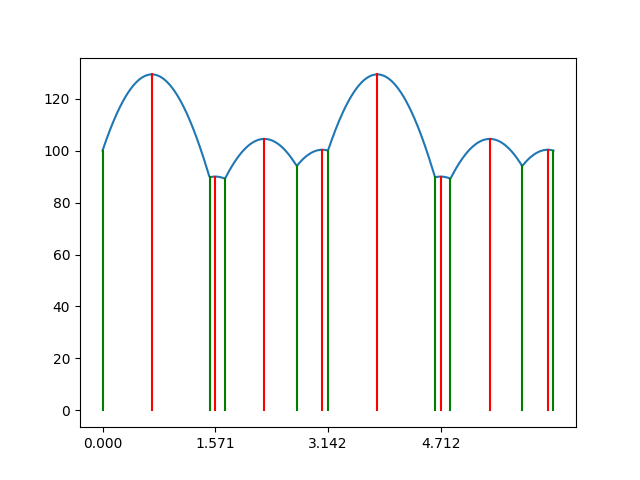

In [23]:
piecewise_func, diameter_func = make_diameter_function(ch)

x = np.linspace(0, 2*np.pi, 500)
y = np.array([diameter_func(t) for t in x])

plt.figure()
plt.plot(x, y)
plt.xticks(np.arange(0, 2*np.pi, np.pi/2))

maxima, minima = find_extrema(piecewise_func, diameter_func)

for m in maxima:
    plt.plot([m, m], [0, diameter_func(m)], color='r')
for m in minima:
    plt.plot([m, m], [0, diameter_func(m)], color='g')

plt.show()

In [24]:
def make_squeeze_func(piecewise_func, diameter_func):
    maxima, minima = find_extrema(piecewise_func, diameter_func)
    
    ranges = np.concatenate(([0], maxima, [2*np.pi]))
    def squeeze_func(theta):
        theta = theta % (2*np.pi)
        for i in range(len(ranges)-1):
            if ranges[i] <= theta < ranges[i+1]:
                assert ranges[i] <= minima[i] <= ranges[i+1]
                return minima[i]
            
        return 2*np.pi
    
    return squeeze_func

class SInterval:
    def __init__(self, a, b, image_min, image_max):
        assert a <= b
        assert image_min <= image_max or np.isclose(image_min, image_max)
        
        self.a = a
        self.b = b
        self.image_min = image_min
        self.image_max = image_max
        
        self.interval_m = self.b - self.a
        self.image_m = self.image_max - self.image_min
        
    def __repr__(self):
        return f'SInterval({round(self.a, 3)}, {round(self.b, 3)}, {round(self.image_min, 3)}, {round(self.image_max, 3)}, ' + \
               f'{round(self.interval_m, 3)}, {round(self.image_m, 3)})'

<IPython.core.display.Javascript object>


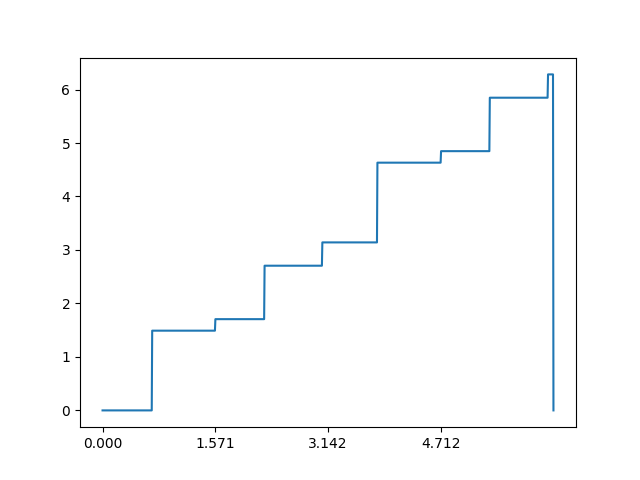

In [25]:
squeeze_func = make_squeeze_func(piecewise_func, diameter_func)

x = np.linspace(0, 2*np.pi, 1000)
y = np.array([squeeze_func(t) for t in x])

plt.figure()
plt.plot(x, y)
plt.xticks(np.arange(0, 2*np.pi, np.pi/2))
plt.show()

In [26]:
s_intervals = []

max_single_step = SInterval(0, 0, 0, 0)
ranges = np.concatenate(([0], maxima, [2*np.pi]))
for i in range(len(ranges)-1):
    curr = ranges[i+1] - ranges[i]
    max_r = max_single_step.b - max_single_step.a
    if curr > max_r and not np.isclose(curr, max_r):
        max_single_step = SInterval(ranges[i], ranges[i+1], minima[i], minima[i])
        
s_intervals.append(max_single_step)

print(max_single_step)

all_s_intervals = []
for i in range(len(ranges)-1):
    for j in range(i+1, len(ranges)):
        if not np.isclose(minima[i], minima[j-1]):
            all_s_intervals.append(SInterval(ranges[i], ranges[j], minima[i], minima[j-1]))


def compare_interval(s1, s2):
    if not np.isclose(s1.image_m, s2.image_m):
        return s1.image_m - s2.image_m
    elif not np.isclose(s1.interval_m, s2.interval_m):
        return s1.interval_m - s2.interval_m
    return 0

def compare_interval2(s1, s2):
    s1 = all_s_intervals[s1]
    s2 = all_s_intervals[s2]
    if not np.isclose(s1.interval_m, s2.interval_m):
        return s2.interval_m - s1.interval_m
    elif not np.isclose(s1.a, s2.a):
        return s1.a - s2.a
    return 0

all_s_intervals.sort(key=functools.cmp_to_key(compare_interval))

# pprint.pprint(all_s_intervals)
# all_s_intervals.sort(key=lambda s: s.interval_m)
# all_s_intervals.sort(key=lambda s: s.image_m)

while any(map(lambda s: s.image_m < s_intervals[len(s_intervals)-1].interval_m, all_s_intervals)):
    valid_ints = []
    idx = 0
    while idx < len(all_s_intervals) and \
          all_s_intervals[idx].image_m < s_intervals[len(s_intervals)-1].interval_m and \
          not np.isclose(all_s_intervals[idx].image_m, s_intervals[len(s_intervals)-1].interval_m):
        valid_ints.append(idx)
        idx += 1

    valid_ints.sort(key=functools.cmp_to_key(compare_interval2))
    # pprint.pprint([all_s_intervals[i] for i in valid_ints])
    # s_intervals.append(all_s_intervals.pop(valid_ints[0]))
    if not np.isclose((n:=all_s_intervals.pop(valid_ints[0])).interval_m, s_intervals[len(s_intervals)-1].interval_m):
        s_intervals.append(n)
    else:
        break
    
s_intervals

SInterval(0.687, 1.571, 1.491, 1.491, 0.884, 0.0)


[SInterval(0.687, 1.571, 1.491, 1.491, 0.884, 0.0),
 SInterval(2.255, 3.828, 2.706, 3.142, 1.574, 0.436),
 SInterval(0.687, 3.062, 1.491, 2.706, 2.375, 1.215),
 SInterval(0.687, 3.828, 1.491, 3.142, 3.142, 1.651)]

In [27]:
plan = [0]

for i in reversed(range(len(s_intervals)-1)):
    eps = .5*(s_intervals[i].interval_m - s_intervals[i+1].image_m)
    alpha = squeeze_func(s_intervals[i+1].a) - s_intervals[i].a - eps + plan[len(plan)-1]
    plan.append(alpha)
    
plan

[0, 0.4419893385181256, -0.5011276212381935, 1.2937195578711362]

<IPython.core.display.Javascript object>


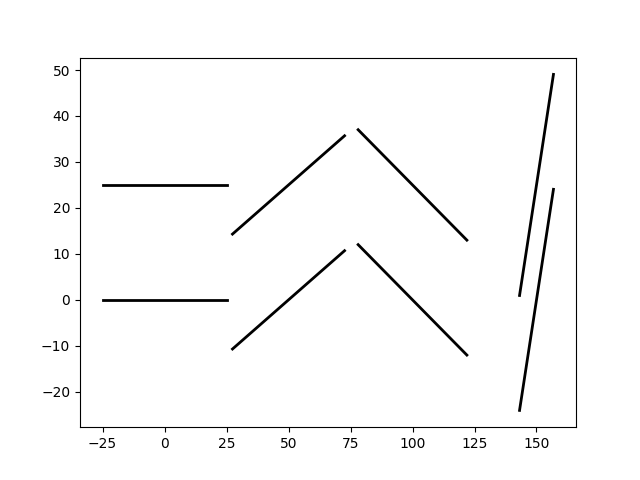

In [41]:
plt.figure()
for p, x in zip(plan, range(0, len(plan)*50, 50)):
    plot_angle((x, 25), p)
    plot_angle((x, 0), p)
    
plt.show()